# Save topic model as an ontology
* Open the trained model
* Create necessary classes and properties

see: https://owlready2.readthedocs.io/en/latest/index.html

In [1]:
import pickle
from owlready2 import *

## Load the trained model
The model was trained in notebook 01_Train_model

In [2]:
with open('../models/lda_nlp_train.pickle', 'rb') as handle:
    ldamodel = pickle.load(handle)

## Load the trained submodels
These models have been trained on each topic.

In [3]:
with open('../models/topic_model.pickle', 'rb') as handle:
    ldasubmodel = pickle.load(handle)

## Convert topics to OWL classes 

In [18]:
import random

# get all topics in the model
topics = ldamodel.show_topics(formatted=False)

# create a new empty ontology
iri = "http://fan.zib.de/aot29/topic_"
ontology = get_ontology(f"{iri}_{random.randint(1,1000000)}.owl")

#################
#   datatypes   #
#################

class WordProbability:
    def __init__(self, word, probability):
        self.word = word
        self.probability = probability

def wp_parser(s):
    splits = s.split(',')
    word = splits[0].strip()
    probability = float(splits[1].strip())
    return(WordProbability(word, probability))
    
def wp_unparser(x):
    return (f"('{x.word}', {x.probability})")    

declare_datatype(WordProbability, f"{iri}#WordProbability", wp_parser, wp_unparser)

def label_clean(topic):
    resp = str([topic[1][i][0] for i in range(0, 3)]).replace('[','').replace(']','').replace('\'','')
#    print(resp)
    return resp

with ontology:

    #################
    #    classes    #
    #################
    
    class Topic(Thing):
        pass

    class has_parent(ObjectProperty):
        domain = [Topic]
        range = [Topic]

    class topic_id(DataProperty, FunctionalProperty):
        domain = [Topic]
        range = [int]

    class label(DataProperty, FunctionalProperty):
        domain = [Topic]
        range = [str]

    class word_probabilities(DataProperty):
        domain = [Topic]
        range = [WordProbability]
    
    #################
    #   instances   #
    #################
    
    # the base topic instance for all topics is NLP
    base_topic = Topic("NLP")
    
    for topic in topics:
        topic_id = topic[0]
        label = label_clean(topic)  # use the first 3 words as the label
        word_probabilities = str(topic[1])
        name = f"{topic_id}: {label}"
        new_topic = Topic(name, has_parent=[base_topic], topic_id=topic_id, label=label, word_probabilities=[word_probabilities])
        # subtopics
        submodel = ldasubmodel[topic_id]
        print(f"{topic_id}: {submodel}")
        subtopics = submodel.show_topics(formatted=False)
        for subtopic in subtopics:
            subtopic_id = f"{topic_id}.{subtopic[0]}"
#            print(subtopic_id)
#            print(sub_name)
            sub_label = label_clean(subtopic)  # use the first 3 words as the label
#            print(sub_label)
            word_probabilities = str(subtopic[1])
#            print(word_probabilities)
            sub_name = f"{topic_id}.{subtopic[0]}: {sub_label}"
            new_subtopic = Topic(sub_name, has_parent=[new_topic], topic_id=subtopic_id, label=sub_label, word_probabilities=[word_probabilities])


0: LdaModel<num_terms=3011, num_topics=5, decay=0.5, chunksize=2000>
1: LdaModel<num_terms=3146, num_topics=7, decay=0.5, chunksize=2000>
2: LdaModel<num_terms=2299, num_topics=9, decay=0.5, chunksize=2000>
3: LdaModel<num_terms=2378, num_topics=10, decay=0.5, chunksize=2000>
4: LdaModel<num_terms=2395, num_topics=11, decay=0.5, chunksize=2000>
5: LdaModel<num_terms=2381, num_topics=5, decay=0.5, chunksize=2000>
6: LdaModel<num_terms=3064, num_topics=13, decay=0.5, chunksize=2000>
7: LdaModel<num_terms=2918, num_topics=8, decay=0.5, chunksize=2000>


In [19]:
ontology.save(file='../data/topics.owl', format='rdfxml')

In [74]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_pydot import pydot_layout

ModuleNotFoundError: No module named 'pydot'

In [21]:
# Load the OWL file
g = rdflib.Graph()
g.parse("../data/topics.owl", format="xml")

http://fan.zib.de/aot29/topic__118999.owl#0: word, embed, semant does not look like a valid URI, trying to serialize this will break.
http://fan.zib.de/aot29/topic__118999.owl#0.0: word, embed, represent does not look like a valid URI, trying to serialize this will break.
http://fan.zib.de/aot29/topic__118999.owl#0: word, embed, semant does not look like a valid URI, trying to serialize this will break.
http://fan.zib.de/aot29/topic__118999.owl#0.1: semant, structur, process does not look like a valid URI, trying to serialize this will break.
http://fan.zib.de/aot29/topic__118999.owl#0: word, embed, semant does not look like a valid URI, trying to serialize this will break.
http://fan.zib.de/aot29/topic__118999.owl#0.2: concept, topic, semant does not look like a valid URI, trying to serialize this will break.
http://fan.zib.de/aot29/topic__118999.owl#0: word, embed, semant does not look like a valid URI, trying to serialize this will break.
http://fan.zib.de/aot29/topic__118999.owl#0.

<Graph identifier=N190dc49c21904086ab756b6a262f4b74 (<class 'rdflib.graph.Graph'>)>

In [101]:
class GraphViz():

    # elements that will be removed frpm the visualization
    filter_terms = ['word_probabilities', 'topic_id', 'domain', 'range', 'Thing', 'NamedIndividual', 'type', 'label']

    node_color = 'lightgray'
    label_font_color =  'gray'
    
    def __init__(self, g):
        # store the graph
        self.g = g
        # Create a NetworkX graph
        self.G = nx.DiGraph()
        # Extract and add triples to the NetworkX graph
        for subj, pred, obj in g:
            if self._filter_out(subj, pred, obj): continue    
            subj_label = self._parse_label(subj)
            pred_label = self._parse_label(pred)
            obj_label = self._parse_label(obj)
            
            self.G.add_edge(subj_label, obj_label, label=pred_label)

    def __str__(self):
        resp = ""
        for subj, pred, obj in g:
            if self._filter_out(subj, pred, obj): continue    
            subj_label = self._parse_label(subj)
            pred_label = self._parse_label(pred)
            obj_label = self._parse_label(obj)
            resp += (f"{subj_label}, {pred_label}, {obj_label}\n")
        return resp
        
    def draw(self):
        # Draw the graph
        #  ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’, 'neato'
        pos = graphviz_layout(self.G, prog="neato")
        plt.figure(figsize=(12, 12))
        nx.draw(self.G, pos, with_labels=True, node_size=3000, node_color=self.node_color, font_size=10, font_weight="normal", arrows=True)
        
        # Draw edge labels
#        edge_labels = {(n1, n2): d['label'] for n1, n2, d in self.G.edges(data=True)}
        edge_labels = {(n1, n2): '' for n1, n2, d in self.G.edges(data=True)}
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels, font_color=self.label_font_color)
    
    def _filter_out(self, subj, pred, obj):
        found = False
        for term in self.filter_terms:
            if (term in subj) or (term in pred) or (term in obj):
                found = True
                break
        return found

    def _parse_label(self, raw):
        raw = str(raw)
        resp = raw
        if '#' in raw:
            resp = raw.split('#')[1]
        return resp

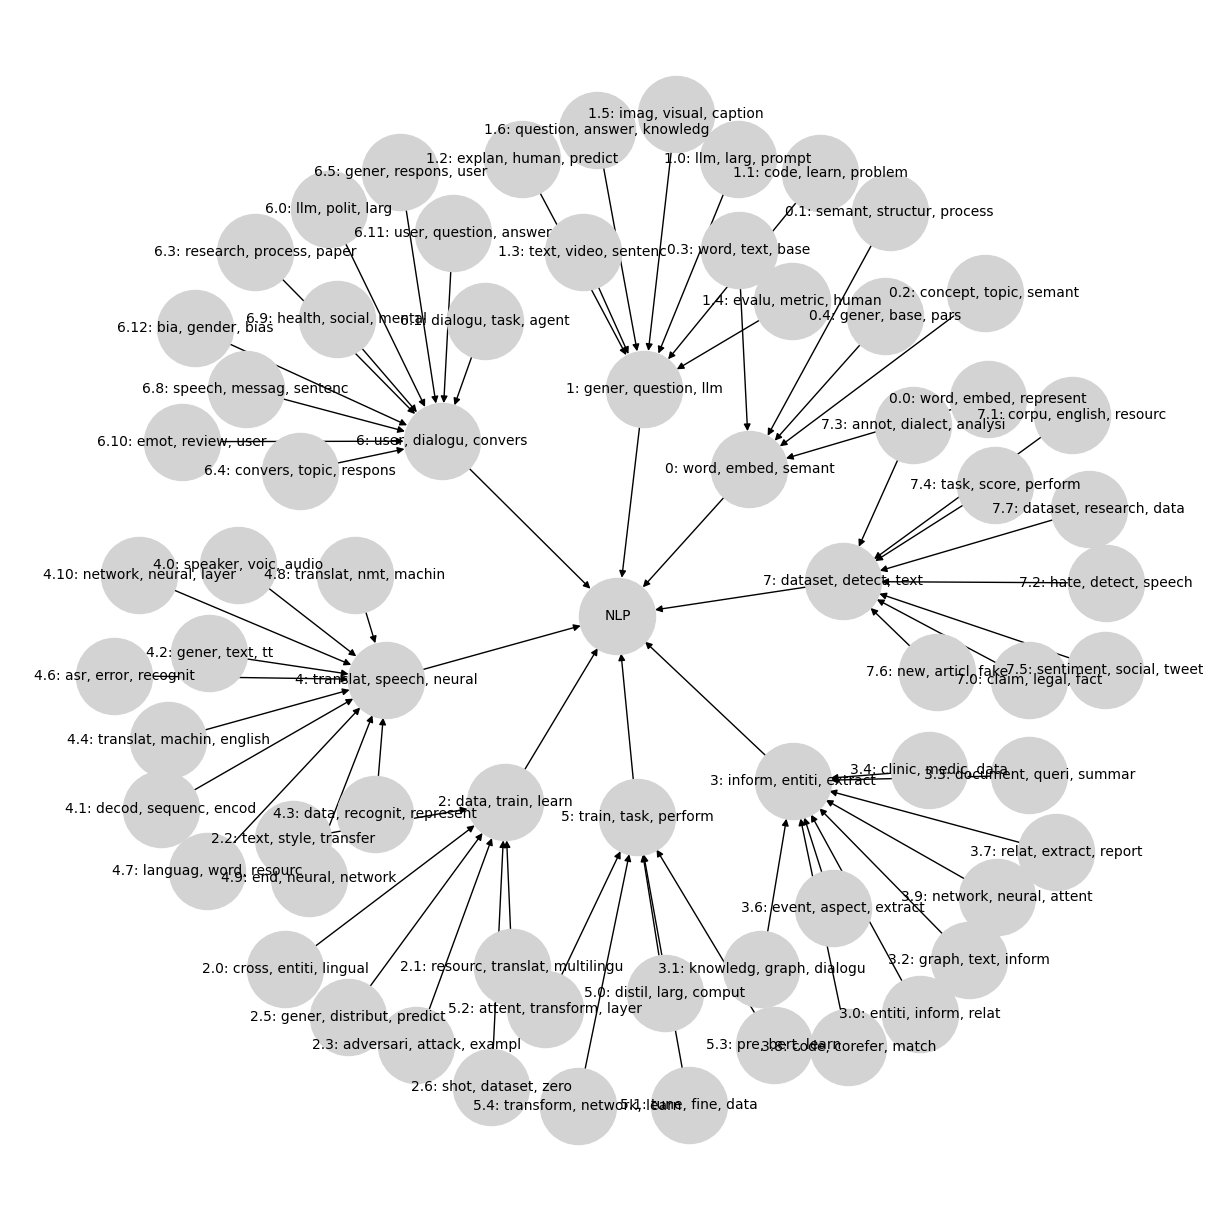

6: user, dialogu, convers, has_parent, NLP
3: inform, entiti, extract, has_parent, NLP
0.1: semant, structur, process, has_parent, 0: word, embed, semant
4.4: translat, machin, english, has_parent, 4: translat, speech, neural
0: word, embed, semant, has_parent, NLP
6.1: dialogu, task, agent, has_parent, 6: user, dialogu, convers
3.0: entiti, inform, relat, has_parent, 3: inform, entiti, extract
6.4: convers, topic, respons, has_parent, 6: user, dialogu, convers
2.3: adversari, attack, exampl, has_parent, 2: data, train, learn
7.7: dataset, research, data, has_parent, 7: dataset, detect, text
6.3: research, process, paper, has_parent, 6: user, dialogu, convers
5.1: tune, fine, data, has_parent, 5: train, task, perform
4.6: asr, error, recognit, has_parent, 4: translat, speech, neural
2.0: cross, entiti, lingual, has_parent, 2: data, train, learn
1.6: question, answer, knowledg, has_parent, 1: gener, question, llm
7.6: new, articl, fake, has_parent, 7: dataset, detect, text
6.11: user, q

In [107]:
g_viz = GraphViz(g)
g_viz.draw()
plt.show()
print(g_viz)
